In [426]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings

from scipy.special import delta

import derivative

In [427]:
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python')
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py')

In [428]:
warnings.filterwarnings("ignore", category=SyntaxWarning)
import lumapi

In [429]:
nm = 1e-9
um = 1e-6
c = 3e8

In [430]:
emeApi = lumapi.MODE()

In [431]:
emeApi.switchtolayout()
emeApi.deleteall()

In [432]:
materialClad = "SiO2 (Glass) - Palik"
materialSi = "Si (Silicon) - Palik"

In [433]:
#slab data
width = 450*nm
height = 220*nm
length = 5*um

In [434]:
emeApi.addstructuregroup()
dev_layer = 'GDS_LAYER_35:4'
emeApi.set('name', dev_layer)

In [435]:
emeApi.addrect()
emeApi.addtogroup(dev_layer)
emeApi.set('name','slab')
emeApi.set('x',0)
emeApi.set('x span', length)
emeApi.set('y',0)
emeApi.set('y span', width)
emeApi.set('z',height/2)
emeApi.set('z span', height)
emeApi.set('material', materialSi)

FDE settings - to get neff vs wavelength

In [436]:
emeApi.addfde()
bound_x_offset = 0.5*um
bound_y_offset = 2*um
bound_z_offset = 0.5*um

emeApi.set('solver type', '2D X normal')
emeApi.set('background material', 'SiO2 (Glass) - Palik')
emeApi.set('x',0)
emeApi.set('y', 0)
emeApi.set('y span', width + 2*bound_y_offset)
emeApi.set('z', height/2)

emeApi.set('mesh cells y', 100)
emeApi.set('mesh cells z', 100)
emeApi.set('y min bc', 'Metal')
emeApi.set('y max bc', 'Metal')
emeApi.set('z min bc', 'Metal')
emeApi.set('z max bc', 'Metal')

In [437]:
emeApi.switchtolayout()
emeApi.set('track selected mode', 1)
emeApi.set('number of points', 100)
emeApi.set('wavelength', 1.6*um)
emeApi.set('stop wavelength', 1.5*um)
emeApi.findmodes()
emeApi.selectmode(1)
neff_mode1 = []

emeApi.frequencysweep()

neff_sweep = emeApi.real(emeApi.getdata('FDE::data::frequencysweep', 'neff'))

frequency_sweep = emeApi.getdata('FDE::data::frequencysweep', 'f')

wavelength_sweep = c/frequency_sweep

wavelength_values = np.linspace(1.5*um, 1.6*um, 6)

neff_mode1.append(emeApi.real(emeApi.getdata('mode1', 'neff')))
for i in range(0, len(wavelength_values),1):
    emeApi.switchtolayout()
    emeApi.set('wavelength', wavelength_values[i])
    emeApi.findmodes()
    emeApi.selectmode(1)
    neff_mode1.append(emeApi.real(emeApi.getdata('mode1', 'ng')))


In [438]:
print(neff_mode1)

[2.290615351379138, 4.249111103700431, 4.25614475526675, 4.3442524183545395, 4.347438186967613, 4.349752171312942, 4.324407276312003]


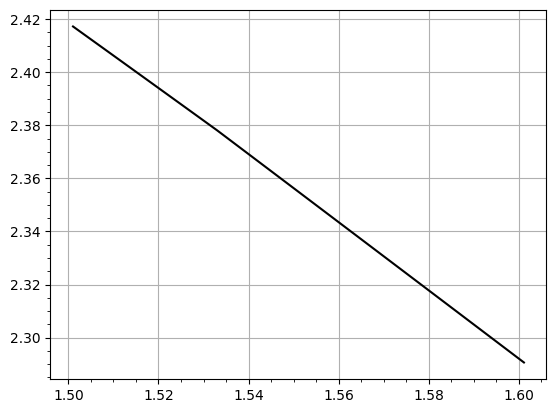

In [439]:
plt.minorticks_on()
plt.grid()
plt.plot(wavelength_sweep/um, neff_sweep, 'black', lw=1.5)

Group index calculation

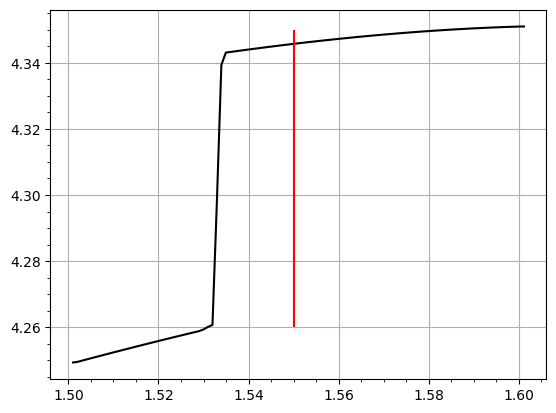

In [440]:
#neff(lambda)
lambda0 = 1550*nm

neff_lambda = np.column_stack((wavelength_sweep, neff_sweep))

derivative_neff = derivative.derivative(neff_lambda)

ng =  neff_sweep.flatten()- (derivative_neff[:,1]*wavelength_sweep.flatten())

plt.grid()
plt.minorticks_on()
plt.plot(derivative_neff[:,0]/um, ng, 'black', lw=1.5)
plt.vlines(1.550,ymin=4.26,ymax=4.35, color='r')

PLOT FSR

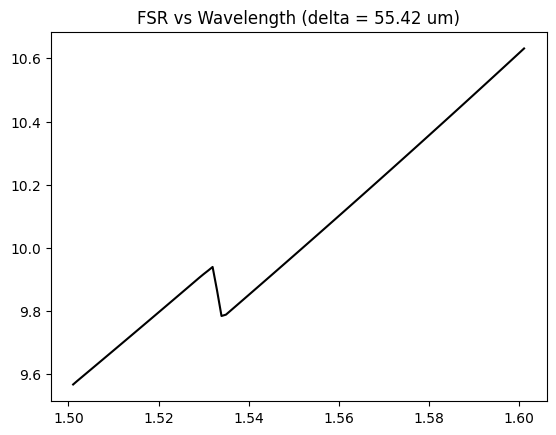

In [454]:
delta = 55.42
fsr = (wavelength_sweep.flatten())**2/(ng*delta*um)

plt.title(f'FSR vs Wavelength (delta = {delta} um)')
plt.plot(wavelength_sweep/um, fsr/nm, 'black', lw=1.5)

Solver settings 

In [455]:
emeApi.switchtolayout()
emeApi.addeme()

In [456]:
#dimensions:
emeApi.set('x',0)
emeApi.set('x min', emeApi.getnamed(f'{dev_layer}::slab', 'x min'))
emeApi.set('y', 0)
emeApi.set('y span', width + 2*bound_y_offset)
emeApi.set('z', height/2)
emeApi.set('z span', height + 2*bound_z_offset)

emeApi.set('group spans',length)

#background material
emeApi.set('background material', materialClad)

In [457]:
#boundary conditions
emeApi.set('y min bc', 'Metal')
emeApi.set('y max bc', 'Metal')
emeApi.set('z min bc', 'Metal')
emeApi.set('z max bc', 'Metal')

In [458]:
emeApi.addemeprofile()
emeApi.set('name', 'profile')
emeApi.set('monitor type', 1)
emeApi.set('x', 2*um)
emeApi.set('y',0)
emeApi.set('y span', emeApi.getnamed('EME', 'y span'))
emeApi.set('z', height/2)

In [459]:
emeApi.save('slab')
emeApi.run()

In [460]:
emeApi.emepropagate()

In [461]:
interval = 0.1
emeApi.setemeanalysis('propagation sweep', 1)
emeApi.setemeanalysis('parameter', 'group span 1')
emeApi.setemeanalysis('start',1*um)
emeApi.setemeanalysis('stop', 1000*um)
emeApi.setemeanalysis('interval', interval)
emeApi.emesweep('propagation sweep')
S = emeApi.getemesweep('S')
group_span = S['group_span_1']

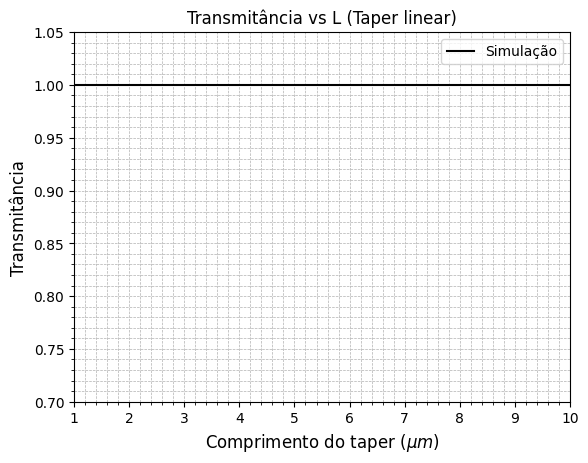

In [462]:
T = np.abs(S['s21'])**2
plt.plot(group_span/um, T, 'black', lw=1.5, label='Simulação')
plt.xlabel(r'Comprimento do taper $(\mu m)$', fontsize = 12)
plt.ylabel('Transmitância', fontsize = 12)
plt.xlim(1,10)
plt.ylim([0.7,1.05])
plt.legend()
plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.title(r'Transmitância vs L (Taper linear)')
plt.grid(True)

In [463]:
emeApi.setemeanalysis('propagation sweep', 1)
emeApi.setemeanalysis('parameter', 'group span 1')
emeApi.setemeanalysis('start',1*um)
emeApi.setemeanalysis('stop', 500*um)
emeApi.setemeanalysis('interval', interval)

In [464]:
emeApi.emesweep('propagation sweep')
S = emeApi.getemesweep('S')
group_span = S['group_span_1']
#group_span = S['group_span_3']
T1 = np.abs(S['s12'])**2
T2 = np.abs(S['s21'])**2
#T3 = np.abs(S['s31'])**2

T1_dB = 10*np.log10(T1)
T2_dB = 10*np.log10(T2)
#T3_dB = 10*np.log10(T3)

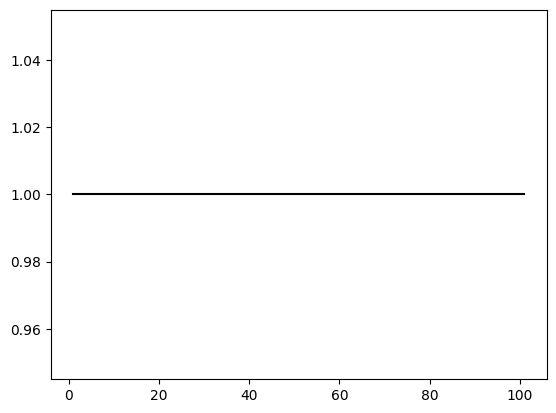

In [465]:
plt.plot(group_span/um, T1, 'black', lw=1.5, label='T1')